In [88]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [143]:
# importando datos
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)

In [144]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/25/23,2/26/23,2/27/23,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209246,209274,209308,209322,209340,209358,209362,209369,209390,209406
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334373,334378,334380,334391,334408,334408,334427,334427,334427,334427
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271439,271440,271440,271441,271448,271463,271469,271469,271477,271477
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47866,47866,47866,47875,47875,47875,47875,47875,47875
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105205,105205,105255,105255,105277,105277,105277,105277,105277,105277


In [145]:
dates = df.columns[4:]
np.array([datetime.strptime(date, '%m/%d/%y') for date in dates])
day_since = np.array([datetime.strptime(date, '%m/%d/%y') for date in dates])

day_zero = day_since[0]
day_zero
datetime

datetime.datetime

*** MODELO SEIR ***
Estableciendo parámetros iniciales de las ecuaciones diferenciales

In [146]:
#Fechas
dates = df.columns[4:]
ydata = np.array(df.iloc[:,4:].sum(axis = 0))
xdata = np.arange(len(dates))
day_since = np.array([datetime.strptime(date, '%m/%d/%y') for date in dates])
day_zero = day_since[0] #datetime.datetime(2020, 1, 22, 0, 0)

# Parámetros iniciales
N = 7_000_000_000  # población mundial
E0 = 1  # número inicial de personas expuestas
I0 = 1  # número inicial de personas infectadas
R0 = 0  # número inicial de personas recuperadas
S0 = N - E0 - I0 - R0  # número inicial de personas susceptibles

# Ecuaciones diferenciales del modelo SEIR
def deriv(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

Ajustando el modelo SEIR a los datos utilizando el método de mínimos cuadrados

In [183]:
# ajustar el modelo SEIR a los datos utilizando el método de mínimos cuadrados
def seir_model(params):
    beta, gamma, sigma = params
    y0 = S0, E0, I0, R0
    ret = odeint(deriv, y0, xdata, args=(N, beta, gamma, sigma))
    return ret.T[2]  # sólo devolver el número de infectados

def gompertz_model(params):
    a, b, c = params
    y_pred = a * np.exp(-b * np.exp(-c * xdata))
    return y_pred

def objective(params):
    seir_pred = seir_model(params[:3])
    gompertz_pred = gompertz_model(params[3:])
    pred = seir_pred * gompertz_pred
    return np.mean((pred - ydata) ** 2)

params0 = [0.1, 0.1, 0.1, 5000, 0.01, 0.01]  # valores iniciales de los parámetros
result = minimize(objective, params0, method='Nelder-Mead')


In [177]:
def seir_model(params):
    beta, gamma, sigma = params
    y0 = S0, E0, I0, R0
    ret = odeint(deriv, y0, xdata, args=(N, beta, gamma, sigma))
    return ret.T[2]  # sólo devolver el número de infectados

In [178]:
seir_model(result.x[:3])[-1]

21690.275717850356

*** GRÁFICA ***

In [148]:
# graficar los resultados de la predicción
beta, gamma, sigma, a, b, c = result.x
y0 = S0, E0, I0, R0
ret = odeint(deriv, y0, np.arange(len(dates)), args=(N, beta, gamma, sigma))
S, E, I, R = ret.T

In [149]:
#calcular la predicción con el modelode Gompertz
pred_x = np.arange(len(dates) + 30)
pred_x

array([   0,    1,    2, ..., 1167, 1168, 1169])

In [150]:
days = pred_x
days

array([   0,    1,    2, ..., 1167, 1168, 1169])

In [151]:
ini_time_for_now = datetime.now()
 
# printing initial_date
print ("initial_date", str(ini_time_for_now))
 
# Calculating future dates
# for two years
future_date_after_2yrs = ini_time_for_now + \
                        timedelta(days = 730)
 
future_date_after_2days = ini_time_for_now + \
                         timedelta(days = 2)

initial_date 2023-03-07 19:28:54.643532


In [152]:
max(days)

1169

In [153]:
for i in range(len(days)):
 pred_days = day_zero + timedelta(days=i)

In [154]:
pred_days

datetime.datetime(2023, 4, 5, 0, 0)

In [155]:
gompertz_pred = a * np.exp(-b * np.exp(-c * pred_x))

In [156]:
pred_days

datetime.datetime(2023, 4, 5, 0, 0)

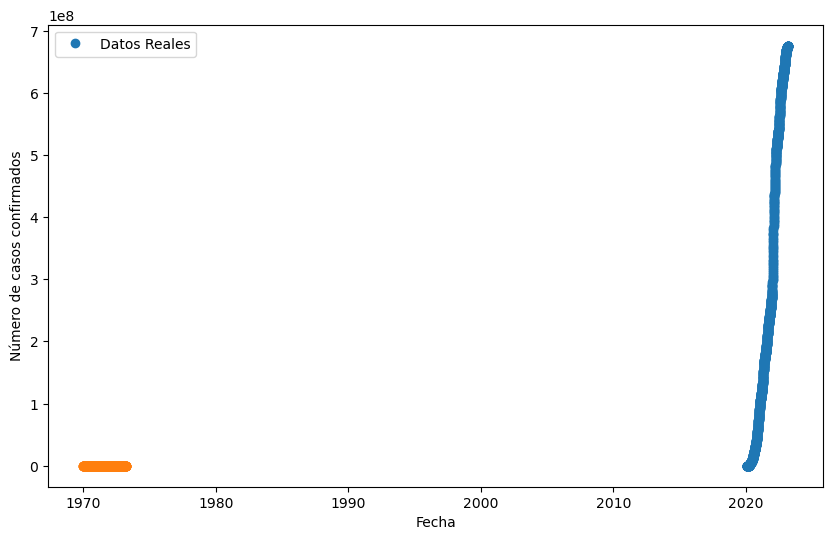

In [186]:
# graficar los resultados
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(day_since, ydata, "o", label="Datos Reales")
ax.set_ylabel("Número de casos confirmados")
ax.legend()
ax.plot(pred_x, gompertz_pred , "o", label="Predicción")#* seir_model(result.x[:3])
ax.set_xlabel("Fecha")
plt.show()

In [158]:
pred_days_v =np.repeat(pred_days_v, [len(seir_model(result.x[:3]))], axis=0)

In [159]:
len(pred_days_v)

1481544000

In [182]:
#str(pred_days_v)
len(gompertz_pred)
#len(pred_x)

1170